# LAB 5: Density Recenstruction, Different Distributions
### Parzen-Rosenblatt, LOO, EM Algorithms
### AI and Machine Learning // Suchkova Natalia М8О-114М-22
20.12.2022 @ MAI IT-Center

### Task
+ реализовать 3 генератора данных на плоскости, прямой или в пространстве (равномерное, Гаусс.распр, ... и др)
+ написать реализацию метода Парзена-Розенблатта
+ восстановить плотность в виде картинки
+ для 1 из 3 наборов данных (п.1) применить оптимизацию ширины окна методом LOO
+ для сгенерированных данных с 2-мя и более горбами применить EM-алгоритм (Gaussian Mixture) из scikit-learn

## Table of Contents

1. [**Релизация генераторов**](#op1)
    - [Равномерное распределение](#op11)
    
    - [Нормальное распределение](#op12)
    
    - [Бимодальное распределение](#op13)
    
    
2. [**Метод Парзена-Розенблатта**](#op2)
    
    
3. [**Восстановление плотностей**](#op3)


4. [**Leave-One-Out**](#op4)


5. [**EM-алгоритм**](#op5)

In [1069]:
import numpy as np
import random
import math

from typing import Mapping

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

In [1070]:
rand = np.random.RandomState(seed=11)

<a id='op1'></a>
## Генераторы данных

<a id='op11'></a>
#### Равномерное (линейное) распределение

Cumulative distribution is:
$$
F(x) = \left\{
    \begin{array}\\
        0, & \text{for } x < a\\
        \frac{x-a}{b-a}, & \text{for }  a \leq x \leq b \\
        1, & \text{for } x > b\\
    \end{array}
\right.
$$


In [1071]:
def genr_uniform(a:float = 0.0, b:float = 1.0, size:int = 1000) -> np.array:
    """
    Function: 
    Метод генерации точек по равномерному распределению с указанными параметрами а и b.

    Args: 
    a: float (default: 0.) - параметр рспределения: левая граница отрезка.
    b: float (default: 1.) - параметр рспределения: правая граница отрезка.
    size: int (default: 1000) - параметр генерацииЖ размер массива.

    Return:
    Массив значений случайно сгенерированных точек (float) при заданных параметрах равномерного
    распределения.
    """
    dist = rand.uniform(a, b, size=(3, size))
    return dist

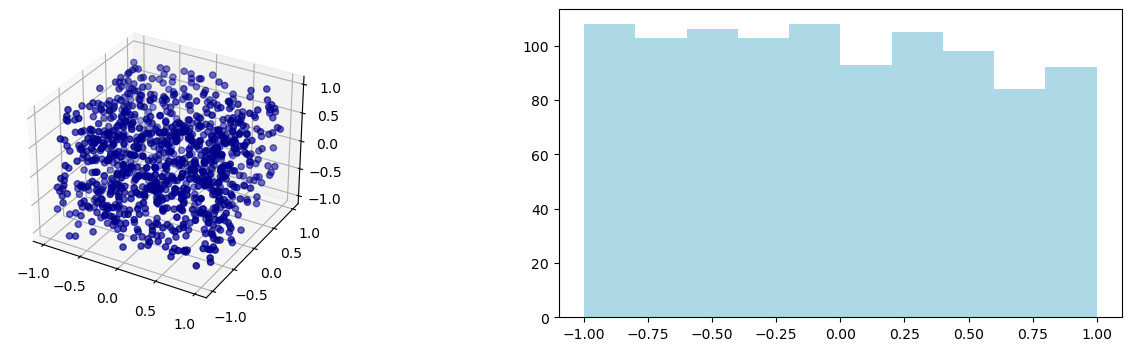

In [1074]:
uni_data = genr_uniform(a=-1.)

fig = plt.figure(figsize=(16, 4))
# ax = plt.axes(projection="3d")
# ax.scatter3D(uni_dist[0], uni_dist[1], uni_dist[2])

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.scatter3D(uni_data[0], uni_data[1], uni_data[2], color='darkblue')

ax = fig.add_subplot(1, 2, 2)
plt.hist(uni_data[1], color='lightblue')
plt.show()

<a id='op12'></a>
#### Гауссовское (нормальное) распределение
Cumulative distribution is:
$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty}^x e^{{}^-t^2/_2}\,\mathrm{d}x $$

In [1075]:
def genr_normal(center: float = 0., std: float = 0.5, size: int = 1000) -> np.array:
    """
    Function: 
    Метод генерации точек по нормальному распределению с указанными параметрами center и std.

    Args: 
    center: float (default: 0.) - параметр рспределения: "центр" распределения.
    std: float (default: 0.5) - параметр рспределения: стандартное отклонение [0, 1].
    size: int (default: 1000) - параметр генерацииЖ размер массива.

    Return:
    Массив значений случайно сгенерированных точек (float) при заданных параметрах равномерного
    распределения.
    """
    dist = rand.normal(center, std, size=(3, size))
    return dist

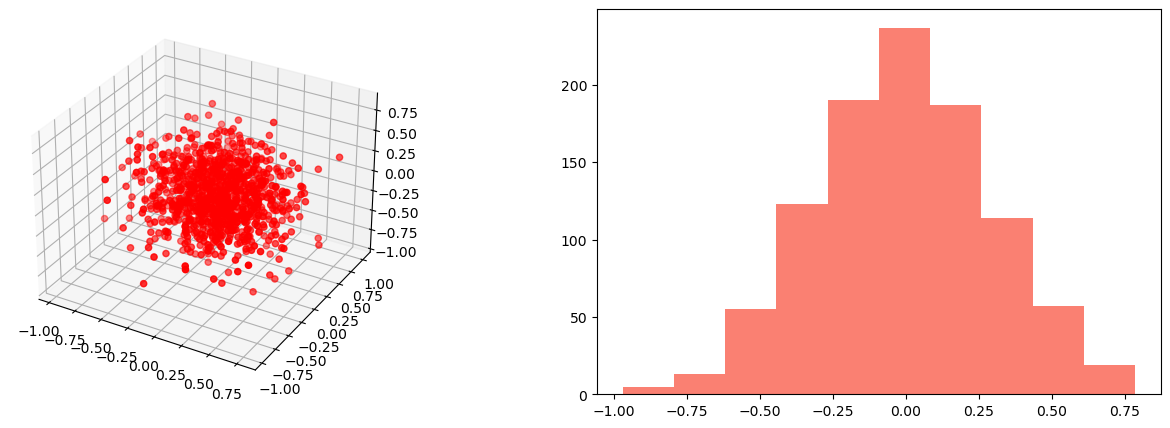

In [1088]:
norm_data = genr_normal(std=0.3)

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.scatter3D(norm_data[0], norm_data[1], norm_data[2], color='red')

ax = fig.add_subplot(1, 2, 2)
plt.hist(norm_data[0], color='salmon')

plt.show()

<a id='op13'></a>
#### Бимодальное распределение (два пика)
Представляет собой сумму ограниченных распределений (любого типа) с различными параметрами.

In [1089]:
# кривовато работает
def genr_mulmodal(n_peaks: int = 2, points: int = 1000) -> np.array:
    """
    Function: 
    Метод генерации точек с двумя горбами.

    Args: 
    n_peaks: int (default: 2) - параметр генерации: количество горбов.
    points: int (default: 1000) - параметр генерации: количество точек.

    Return:
    Массив значений случайно сгенерированных точек (float) при заданных параметрах.
    """
    dist = rand.poisson(10, size=(3, points // n_peaks))
    for p in range(n_peaks - 2):
        peak = rand.normal(-10, 0.1, size=(3, points // n_peaks))
        np.append(dist, peak)
    peak2 = rand.lognormal(mean=0.4, sigma=1.5, size=(3, points // n_peaks))
    np.append(dist, peak2)
    return dist

In [1190]:
def genr_bimodal(size: int = 1000) -> np.array:
    peak1 = genr_normal(-2, 3, size // 2)
    peak2 = genr_normal(5, 1, size // 2)
    return np.concatenate((peak1, peak2), axis=1)

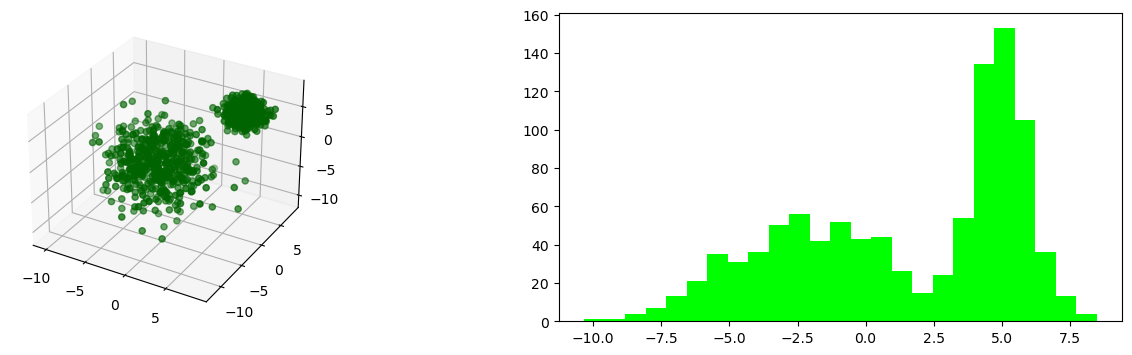

In [1193]:
bi_data = genr_bimodal()
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.scatter3D(bi_data[0], bi_data[1], bi_data[2], color='darkgreen')

ax = fig.add_subplot(1, 2, 2)
plt.hist(bi_data[0], bins=25, color='lime')
# fig.subplots_adjust(wspace=.1)

plt.show()

<a id='op2'></a>
## Метод Парзена-Розенблатта

Оценка плотности Парзена-Розенблатта или, иначе, ядерная оценка плотности — это непараметрический способ оценки плотности случайной величины. Ядерная оценка плотности является задачей сглаживания данных, когда делается заключение о совокупности, основываясь на конечных выборках данных.

Оценка плотности Парзена-Розенблатта в одномерном случае имеет вид:

$$\hat{f_h}(x) = \frac{1}{n}\displaystyle\sum_{i=1}^{n} K_h(x-x_i) = \frac{1}{nh}\displaystyle\sum_{i=1}^{n} K(\frac{x-x_i}{h})$$

где  $K$- ядро (неотрицательная, четная, нормированная функция), $h > 0$ - сглаживающий параметр, ширина окна. В качестве ядра можно использовать функции Коши или Гаусса, например: 
$$\text{ядро Гаусса}: K(x) = \frac{1}{\sigma\sqrt{2\pi}}  e^\frac{(x-\mu)^2}{2\sigma^2}$$ 

$K_h(x)$ называется взвешенным ядром, и определяется как $K_h(x) = {}^1/_h K({}x/_h)$.

Интуитивно стараются выбрать h как можно меньше, насколько данные это позволяют, однако всегда существует выбор между смещением оценщика и его дисперсией. Существует ряд наиболее часто используемых ядерных функций, в том числе: 

kernel ='cosine': K(a;h)∝cos(πa/2h) if|a|< h

kernel = 'epanechnikov':  K(a;h)∝1−a^2/h^2

kernel = 'exponential':  K(a;h)∝exp(−|a|/h)

kernel = 'gaussian':    K(a;h)∝exp(−a^2/2h^2)

kernel = 'linear':     K(a;h)∝1−|a|/h if|a|< h

kernel = 'tophat':   K(a;h)∝1 if|a|<h
                                      

In [426]:
gauss_kernel = lambda x: ((2 * math.pi) ** (-1/2)) * np.exp(-1/2 * (x ** 2))

In [442]:
distance = lambda point1, point2: math.sqrt((point1[0] - point2[0]) ** 2\
                                            + (point1[1] - point2[1]) ** 2\
                                            + (point1[2] - point2[2]) ** 2
                                           )

In [457]:
def ParzRos_score(x: float, h: float, data: np.array, kernel: Mapping, distance: Mapping) -> float:
    """
    Function: 
    Метод возвращает значение, найденное методом Парзена-Розенблатта для группы точек.

    Args: 
    x: float - параметр функции ядра.
    h: float - параметр метода Парзена-Розенблатта: ширина окна.
    data: list или array - набор точек.
    kernel: Mapping - тип ядра.
    distance: Mapping - функция расчета расстояния между двумя точками 
                        на плоскости или в пространстве (для нелинейной задачи).

    Return:
    Значение найденное методом Парзена-Розенблатта для группы точек (float).
    """
    return sum([kernel(distance(x, point) / h) for point in data]) / (len(data) * h)

<a id='op3'></a>
## Восстановление плотностей

Если **линейная задача** выполняется на данных linspace 

>`x = np.linspace(min, max, size)`,

то для задач на плоскости и в пространстве должны быть сетки соответствующих размерностей.

Для задачи на **плоскости** 

>`X, Y = np.mgrid[-1:1:20j, -1:1:20j]`

>`xy = np.vstack((X.flatten(), Y.flatten())).T`

In [1136]:
X, Y, Z = np.mgrid[-5:5:10j, -5:5:10j, -5:5:10j]
xyz = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T

all_x = [p[0] for p in xyz]
all_y = [p[1] for p in xyz]
all_z = [p[2] for p in xyz]

In [1137]:
xyz

array([[-5.        , -5.        , -5.        ],
       [-5.        , -5.        , -3.88888889],
       [-5.        , -5.        , -2.77777778],
       ...,
       [ 5.        ,  5.        ,  2.77777778],
       [ 5.        ,  5.        ,  3.88888889],
       [ 5.        ,  5.        ,  5.        ]])

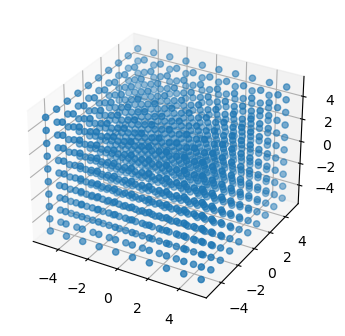

In [1138]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(projection="3d")
ax.scatter3D(all_x, all_y, all_z)
plt.show()

Полезные статьи, которые помогли
- https://sebastianraschka.com/Articles/2014_kernel_density_est.html 
- https://www.mathworks.com/help/matlab/ref/trisurf.html
- https://matplotlib.org/stable/gallery/mplot3d/trisurf3d_2.html
- https://stackabuse.com/kernel-density-estimation-in-python-using-scikit-learn/
- https://stackabuse.com/generating-synthetic-data-with-numpy-and-scikit-learn/

#### Равномерное распределение

In [1139]:
X, Y = np.mgrid[-5:5:100j, -5:5:100j]
xyz = np.vstack((X.flatten(), Y.flatten())).T

all_x = [p[0] for p in xyz]
all_y = [p[1] for p in xyz]

In [1157]:
def plot_recovered(data, h: float, z_uplim: float, cmap, title: str):
    pr = [ParzRos_score(point[:2], h, data, gauss_kernel, distance) for point in xyz]
    ax = plt.figure().add_subplot(projection='3d')
    surf = ax.plot_trisurf(np.array(all_x), np.array(all_y), np.array(pr), 
                           cmap=cmap, linewidth=0, antialiased=False)
    
#     ax.set_xlim(-6, 0)
#     ax.set_ylim(-6, 0)
    ax.set_zlim(0, z_uplim)
    
    ax.set_title('Восстановление плотности: ' + title + f'. Параметры: h = {h}.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('p`(x, y)')

    plt.show()

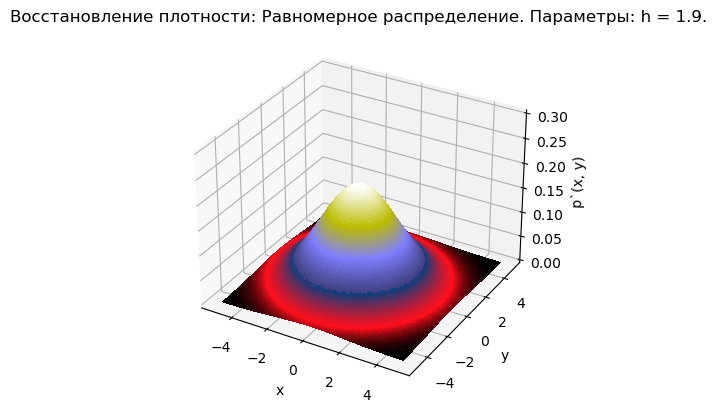

In [1141]:
plot_recovered(uni_data, 1.9, 0.3, cm.gist_stern, 'Равномерное распределение')

#### Нормальное распределение

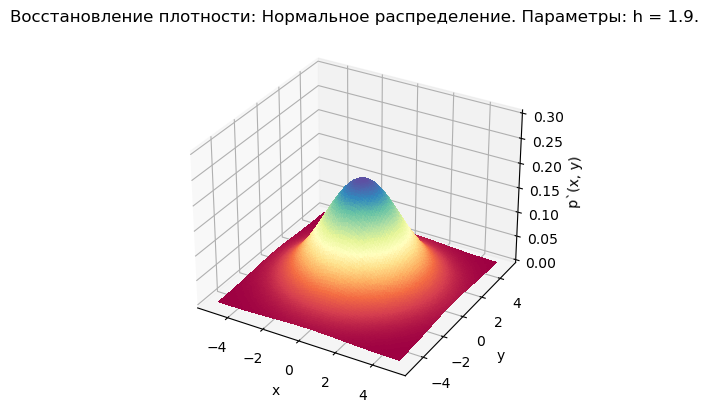

In [1142]:
plot_recovered(norm_data, 1.9, 0.3, cm.Spectral, 'Нормальное распределение')

#### Бимодальное распределение

In [1198]:
X, Y, Z = np.mgrid[-5:5:50j, -5:5:50j, -5:5:50j]
xyz = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T

all_x = [p[0] for p in xyz]
all_y = [p[1] for p in xyz]
all_z = [p[2] for p in xyz]

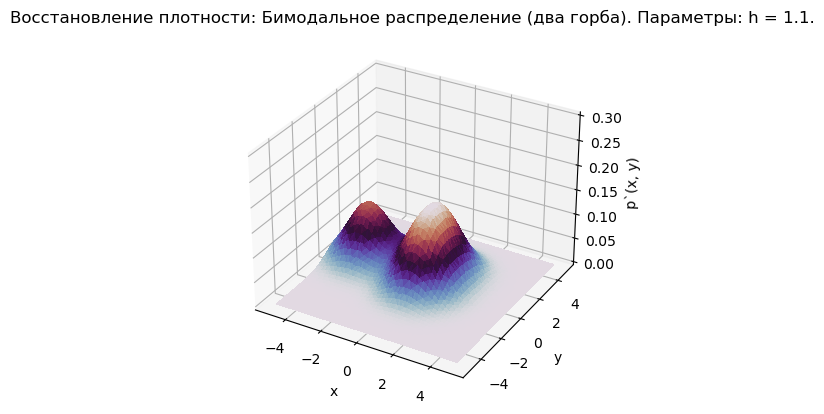

In [1201]:
plot_recovered(bi_data, 1.1, 0.3, cm.twilight, 'Бимодальное распределение (два горба)')

<a id='op4'></a>
## Leave-One-Out

$$LOO(h, X^l) = -\displaystyle\sum_{i=1}^{l} ln \bigg\lbrack \hat{p_h}\big(x_i; \frac{X^l}{x_i}, h\big) \bigg\rbrack \to \min_h$$

Решим задачу для бимодального распределения на одномерных данных. Для этого слегка переделаем функции и создадим одномерные данные.

In [1202]:
def genr_normal2(center: float = 0., std: float = 0.5, size: int = 1000) -> np.array:
    """
    Function: 
    Метод генерации точек по нормальному распределению с указанными параметрами center и std.

    Args: 
    center: float (default: 0.) - параметр рспределения: "центр" распределения.
    std: float (default: 0.5) - параметр рспределения: стандартное отклонение [0, 1].
    size: int (default: 1000) - параметр генерацииЖ размер массива.

    Return:
    Массив значений случайно сгенерированных точек (float) при заданных параметрах равномерного
    распределения.
    """
    dist = rand.normal(center, std, size)
    return dist

In [1205]:
def genr_bimodal2(size: int = 1000) -> np.array:
    peak1 = genr_normal2(-5, 1, size // 2)
    peak2 = genr_normal2(5, 3, size // 2)
    return np.concatenate((peak1, peak2)) 

In [1206]:
bi_data2 = genr_bimodal2()

In [1231]:
len(bi_data2)

1000

In [1230]:
bi_data2

array([-5.73548006, -4.70208995, -5.30973381, -5.61035229, -4.1658259 ,
       -5.49060356, -4.44753594, -6.13641288, -3.62992575, -3.81992872,
       -4.67492029, -5.13873565, -5.96417319, -6.01901372, -2.92581488,
       -4.0697869 , -4.70662249, -4.602072  , -4.04016373, -4.52771397,
       -4.04180627, -4.85999521, -4.66914236, -5.51827229, -4.81776733,
       -6.62025383, -4.65223633, -4.63716944, -3.63786277, -5.13167103,
       -3.47942769, -3.98089127, -4.40652494, -3.63916351, -3.75261177,
       -4.99420436, -4.57362266, -3.66597947, -6.53332142, -4.09230065,
       -4.68989178, -5.43247122, -6.29940213, -4.23102707, -6.10854181,
       -6.8908901 , -4.93383871, -5.45655514, -4.34841576, -4.91851909,
       -5.3948822 , -4.39003911, -4.18736824, -5.8336055 , -3.34968795,
       -5.40569429, -5.25778527, -7.3468872 , -5.28434148, -5.76355586,
       -3.23617807, -4.63255992, -6.13455051, -4.57508772, -3.95127513,
       -3.97101738, -6.30196198, -6.78735742, -4.25689885, -4.46

In [1209]:
def ParzRos_score2(x: float, h: float, data: np.array, kernel: Mapping) -> float:
    """
    Function: 
    Метод возвращает значение, найденное методом Парзена-Розенблатта для группы точек.

    Args: 
    x: float - параметр функции ядра.
    h: float - параметр метода Парзена-Розенблатта: ширина окна.
    data: list или array - набор точек.
    kernel: Mapping - тип ядра.
    distance: Mapping - функция расчета расстояния между двумя точками 
                        на плоскости или в пространстве (для нелинейной задачи).

    Return:
    Значение найденное методом Парзена-Розенблатта для группы точек (float).
    """
    return sum([kernel((x - point) / h) for point in data]) / (len(data) * h)

In [1254]:
def plot_2D(data: list, title: str, c1: float, std1: float, c2, std2,
            h: float = 0.3, size: int = 1000, color: list = ['slateblue', 'goldenrod']):
    x = np.linspace(min(data), max(data), size)
    points = np.zeros((1000))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(x, ParzRos_score2(x, h, data, gauss_kernel), color=color[0])
    ax.scatter(data, points, marker = "|", color=color[1])
    
    ax.set_xlim((min(data), max(data)))
    ax.set_title("Восстановление плотности распределения: " + title + f". Параметры: c_1={c1},\
    std_1={std1}, c_2={c2}, std_2={std2}, h={h}.", fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel("p'(x)")
    plt.show()

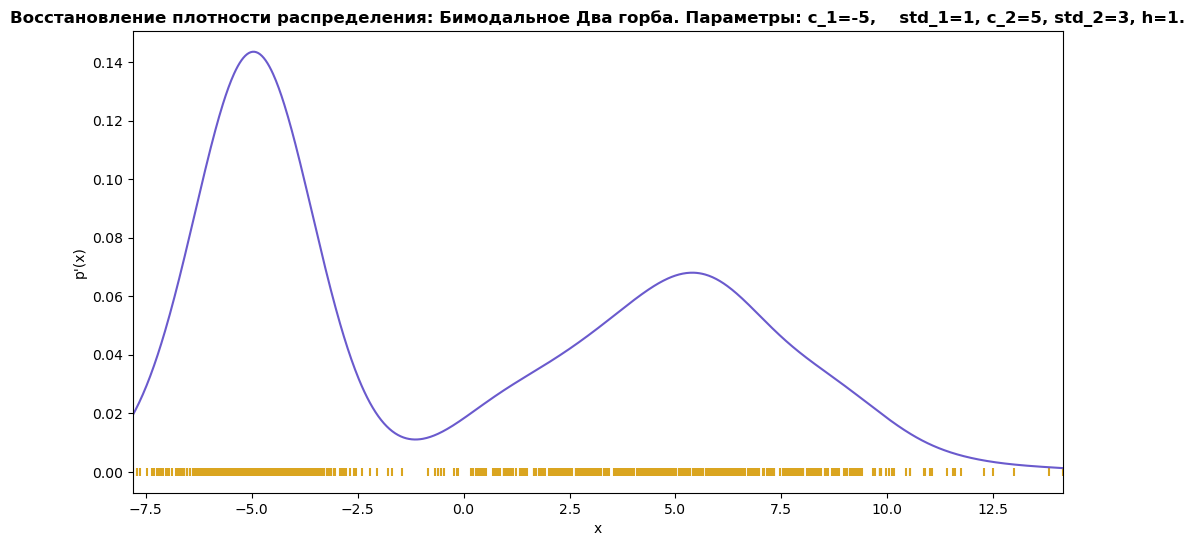

In [1255]:
plot_2D(bi_data2, 'Бимодальное Два горба', -5, 1, 5, 3, 1)

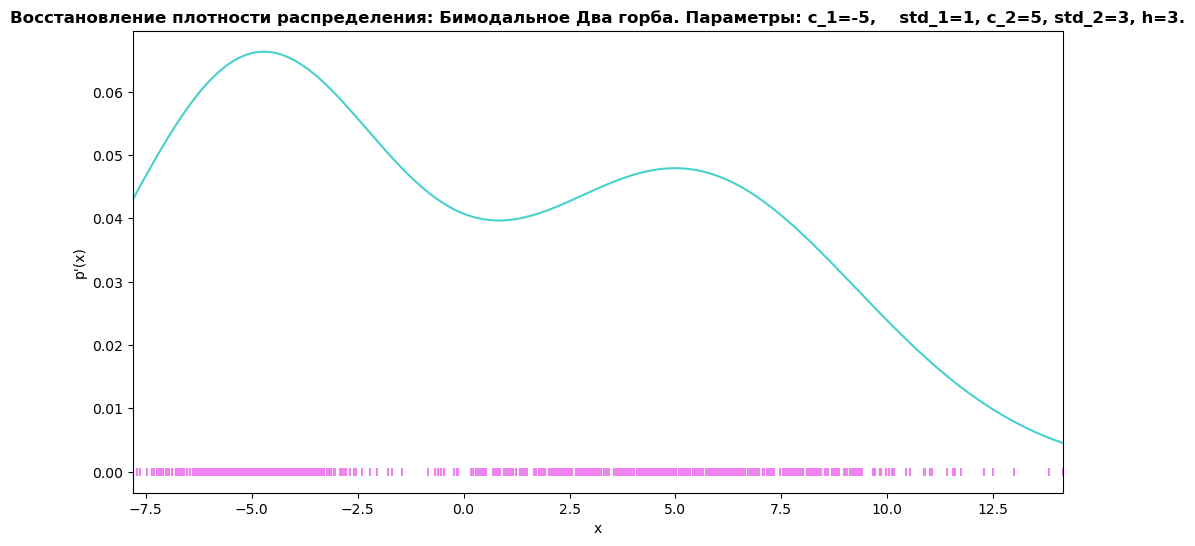

In [1260]:
plot_2D(bi_data2, 'Бимодальное Два горба', -5, 1, 5, 3, 3, 1000, ['mediumturquoise', 'violet'])

In [1310]:
def LOO(data: list, h: float) -> float:
    """
    Function: реализация метода leave-one-out.

    Args:
    data: list - массив данных.
    h: float - ширина окна.

    Return: значение оптимизированной ширины окна (float).
    """
    return -sum([math.log(ParzRos_score2(data[i], h, data[:i] + data[i+1:], gauss_kernel)) for i in range(len(data))])

print(f"Значение по м. LOO для h = 1: {LOO(bi_data2.tolist(), 1)}.")

Значение по м. LOO для h = 1: 2673.5575072875026.


Теперь подберем оптимальное значение h из диапазона [0.1, 10].

In [1313]:
h_s

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1,
       5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7,
       7.9, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.3, 9.5, 9.7, 9.9])

In [1314]:
%%time
h_s = np.arange(0.1, 5.05, 0.05)
loo_min = 100000

for h in h_s:
    loo_cur = LOO(bi_data2.tolist(), h)
    if  loo_cur < loo_min:
        loo_min = loo_cur
        h_min = h


print(f"LOO при стартовом значении h=10: {LOO(bi_data2.tolist(), h)}")
print(f"LOO при опимальном значении h={h_min}: {loo_min}")

LOO при стартовом значении h=10: 3175.946162148749
LOO при опимальном значении h=0.45000000000000007: 2636.703193084793
Wall time: 5min 15s


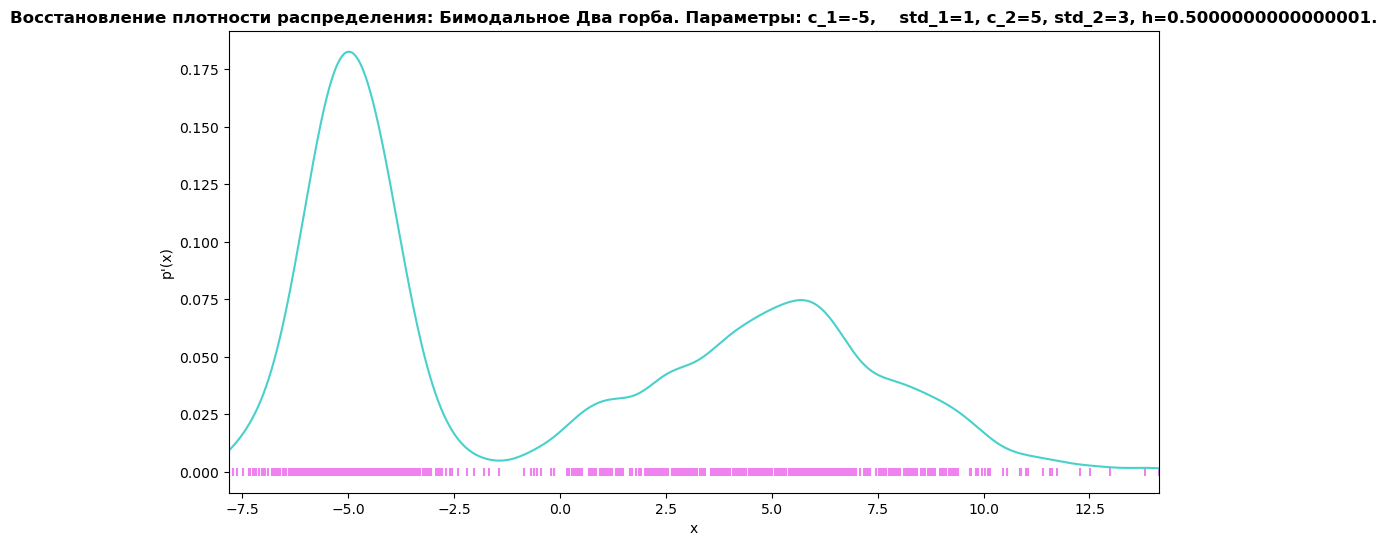

In [1312]:
plot_2D(bi_data2, 'Бимодальное Два горба', -5, 1, 5, 3, h_min, 1000, ['mediumturquoise', 'violet'])

<a id='op5'></a>
## ЕМ - алгоритм

M-алгоритм (англ. Expectation-maximization (EM) algorithm) — алгоритм, используемый в математической статистике для нахождения оценок максимального правдоподобия параметров вероятностных моделей, в случае, когда модель зависит от некоторых скрытых переменных. Каждая итерация алгоритма состоит из двух шагов. На E-шаге (expectation) вычисляется ожидаемое значение функции правдоподобия, при этом скрытые переменные рассматриваются как наблюдаемые. На M-шаге (maximization) вычисляется оценка максимального правдоподобия, таким образом увеличивается ожидаемое правдоподобие, вычисляемое на E-шаге. Затем это значение используется для E-шага на следующей итерации. Алгоритм выполняется до сходимости.

**Часто EM-алгоритм используют для разделения смеси гауссиан.**

In [1295]:
from sklearn.mixture import GaussianMixture

In [1296]:
bi_data

array([[ 0.57863676, -0.54209607,  0.81133597, ...,  6.02732771,
         5.24669468,  6.03549985],
       [-3.2171244 ,  0.72117956, -1.91477781, ...,  5.94938147,
         3.99798375,  4.7512922 ],
       [ 0.46939608,  1.50007234,  0.92336469, ...,  5.69050592,
         5.20281569,  6.87729397]])

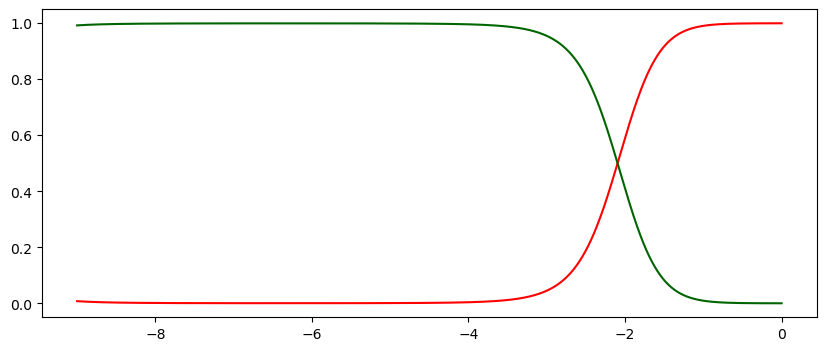

In [1308]:
X = bi_data2.reshape(-1, 1)
gm = GaussianMixture(n_components=2, covariance_type='full', random_state=11).fit(X)
gm.means_
fig = plt.figure(figsize=(10, 4))

x2 = np.linspace(-9, 0, 1000)
y_1 = gm.predict_proba(x2.reshape(-1, 1))[:,0]
y_2 = gm.predict_proba(x2.reshape(-1, 1))[:,1]

plt.plot(x2, y_1, color = 'red')
plt.plot(x2, y_2, color = 'darkgreen') 
plt.show()